In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

In [2]:
def plot_pr_curve(y: np.ndarray, y_score: np.ndarray, title: str, ax=None):
    _prec, _rec, _ = precision_recall_curve(y, y_score=y_score)
    PrecisionRecallDisplay(_prec, _rec).plot(ax=ax, name=f"{title}")

$$prec = \frac{tp}{tp + fp} \qquad rec = \frac{tp}{tp + fn}$$

olgu mudel $N$, mis hinab andmepunte juhuslikult ühtlasest jaotusest $S \sim U(0, 1)$
$$\hat{y} = 
\begin{cases}
        0, & \text{if } S \leq 0.5 \\
        1, & \text{if } S \gt 0.5
\end{cases}$$

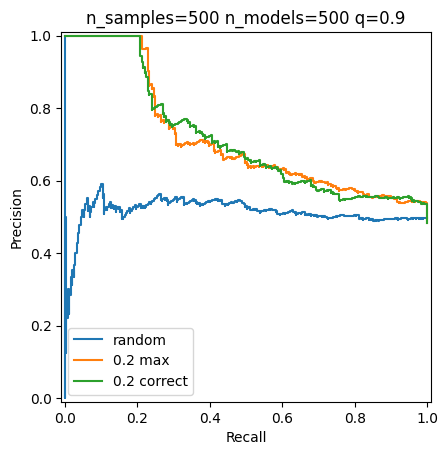

In [3]:
n_samples = 500
n_models = 500
quantile = 0.9
tenth = int(n_samples / 10)
shuffle = np.random.permutation(n_samples)

_, ax = plt.subplots()
ax.set_title(f"n_samples={n_samples} n_models={n_models} q={quantile}")

y_rand = np.random.binomial(n=1, p=0.5, size=n_samples)
y_rigged = np.concat((np.zeros(tenth), np.ones(tenth), np.random.binomial(n=1, p=0.5, size=tenth * 8)))[shuffle]
# E y_rigged = (1/10 * 1) + (1/10 * 0) + (8/10 E y|y~Bin(1, 0.5)) = 0.1 + 0.0 + 0.4 = 0.5 = E y_rand

# random
null_scores = [np.random.uniform(size=n_samples) for _ in range(n_models)]
null_score_q = np.quantile(null_scores, quantile, axis=0)
plot_pr_curve(y_rand, null_score_q, "random", ax=ax)

# 0.2 max
null_20_max_gen = lambda: np.concat((np.zeros(tenth), np.ones(tenth), np.random.uniform(size=tenth * 8)))[shuffle]
null_20_max_scores = [null_20_max_gen() for _ in range(n_models)]
null_20_max_score_q = np.quantile(null_20_max_scores, quantile, axis=0)
plot_pr_curve(y_rigged, null_20_max_score_q, "0.2 max", ax=ax)

# 0.2 correct
null_20_gen = lambda: np.concat((np.random.uniform(low=0.0, high=0.5, size=tenth),
                                np.random.uniform(low=0.5 + 1e-6, high=1.0, size=tenth),
                                np.random.uniform(size=tenth * 8)))[shuffle]
null_20_scores = [null_20_gen() for _ in range(n_models)]
null_20_score_q = np.quantile(null_20_scores, quantile, axis=0)
plot_pr_curve(y_rigged, null_20_score_q, "0.2 correct", ax=ax)